In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## first pass pre made BERT embeddings with continuous variable
- made up data

In [3]:
subj = torch.rand(160,768).numpy()
medhx = torch.rand(160,768).numpy()
cont = torch.rand(160,10).numpy()

In [4]:
labels = torch.randint(0,3,(160,)).numpy()

In [5]:
subj.shape, medhx.shape, cont.shape, labels.shape

((160, 768), (160, 768), (160, 10), (160,))

In [6]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [7]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [8]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [9]:
#hyperparameters
lr = 1
epochs = 10
loss_func = nn.CrossEntropyLoss()

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.linear_combined = nn.Linear(30, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont):
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        combined = torch.cat((nlp1,nlp2,cont), axis = 1)
        x = F.relu(self.linear_combined(combined))
        x = self.out(x)
        return x



In [11]:
net = Net()
net

Net(
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (linear_combined): Linear(in_features=30, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)

### testing the forward method

In [12]:
x1,x2,x3,x4 = next(iter(trainloader))

In [13]:
net(x1,x2,x3)

tensor([[ 0.3076,  0.1748, -0.2668, -0.0997],
        [ 0.4326,  0.1828, -0.1671, -0.1729],
        [ 0.2816,  0.0664, -0.3529, -0.0144],
        [ 0.3620,  0.0901, -0.2825, -0.0466]], grad_fn=<AddmmBackward>)

### trying the training loop

In [14]:
def train_model(model):
    optimizer = Adam(model.parameters(), lr = lr)
    running_loss = []
    for epoch_num in range(epochs):
        model.train()
        train_loss = 0
        for step_num, batch_data in enumerate(trainloader):
        
            cont_var, subj_notes, medhx, labels = tuple(t.to(device) for t in batch_data)
        
            optimizer.zero_grad()
        
            logits = model(cont_var, subj_notes, medhx)#, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            train_loss += batch_loss.item()
        
            batch_loss.backward()
        

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
            optimizer.step()
        
            if step_num %12 == 0:
                print('Epoch: ', epoch_num + 1)
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
            
        running_loss.append(train_loss)

    return running_loss

In [15]:
cum_loss = train_model(net)

Epoch:  1
0/36.0 loss: 1.3358349800109863 
Epoch:  1
12/36.0 loss: 985.2547945426061 
Epoch:  1
24/36.0 loss: 513.0024306845665 
Epoch:  2
0/36.0 loss: 1.128175139427185 
Epoch:  2
12/36.0 loss: 1.1653862045361445 
Epoch:  2
24/36.0 loss: 1.2015890789031982 
Epoch:  3
0/36.0 loss: 1.0959442853927612 
Epoch:  3
12/36.0 loss: 1.137764884875371 
Epoch:  3
24/36.0 loss: 1.1805632257461547 
Epoch:  4
0/36.0 loss: 1.0929811000823975 
Epoch:  4
12/36.0 loss: 1.1317130418924184 
Epoch:  4
24/36.0 loss: 1.1769244384765625 
Epoch:  5
0/36.0 loss: 1.0962785482406616 
Epoch:  5
12/36.0 loss: 1.1305855329220111 
Epoch:  5
24/36.0 loss: 1.1765617084503175 
Epoch:  6
0/36.0 loss: 1.098321795463562 
Epoch:  6
12/36.0 loss: 1.1301328264749968 
Epoch:  6
24/36.0 loss: 1.1764910960197448 
Epoch:  7
0/36.0 loss: 1.099420428276062 
Epoch:  7
12/36.0 loss: 1.1297948818940382 
Epoch:  7
24/36.0 loss: 1.1764164423942567 
Epoch:  8
0/36.0 loss: 1.1000910997390747 
Epoch:  8
12/36.0 loss: 1.1295231168086712 
Ep

In [16]:
cum_loss

[12838.60406333208,
 42.982205629348755,
 42.386277198791504,
 42.31040298938751,
 42.314825773239136,
 42.3207705616951,
 42.32360535860062,
 42.32485604286194,
 42.32542860507965,
 42.32569521665573]

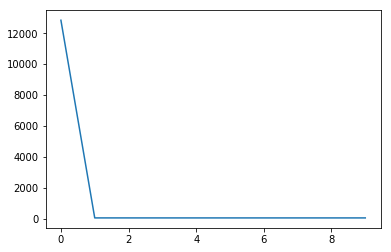

In [17]:
plt.plot(cum_loss)

## now we are going to make the model more complex and add embedding
- still made up data

In [18]:
cats = np.random.randint(1, 30, size=(160))

In [19]:
len(set(cats))

29

In [20]:
#not sure which the best method for embedding filters is but likley # 2
embedding_size = min(50, (len(set(cats))// 2) +1)
embedding_size2 = min(600, round(1.6 * len(set(cats))**0.56))
embedding_size, embedding_size2

(15, 11)

In [21]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_cats, validation_cats = train_test_split(cats, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [22]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_cats = torch.tensor(train_cats)
validation_cats = torch.tensor(validation_cats)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [23]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_cats,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_cats, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [40]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.embedding = nn.Embedding(len(set(cats))+1, 30)
        self.linear_cat = nn.Linear(30,10)
        self.linear_combined = nn.Linear(40, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont,cat_var):
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        embeds = self.embedding(cat_var)
        cats = F.relu(self.linear_cat(embeds))
        combined = torch.cat((nlp1,nlp2,cont,cats), axis = 1)
        x = F.relu(self.linear_combined(combined))
        x = self.out(x)
        return x



In [41]:
def train_model2(model):
    optimizer = Adam(model.parameters(), lr = lr)
    running_loss = []
    for epoch_num in range(epochs):
        model.train()
        train_loss = 0
        for step_num, batch_data in enumerate(trainloader):
        
            cont_var, subj_notes, medhx, cat_var, labels = tuple(t.to(device) for t in batch_data)
        
            optimizer.zero_grad()
        
            logits = model(cont_var, subj_notes, medhx, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            train_loss += batch_loss.item()
        
            batch_loss.backward()
        

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
            optimizer.step()
        
            if step_num %12 == 0:
                print('Epoch: ', epoch_num + 1)
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
            
        running_loss.append(train_loss)

    return running_loss

In [42]:
net = Net1()
print(net)

Net1(
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (embedding): Embedding(30, 30)
  (linear_cat): Linear(in_features=30, out_features=10, bias=True)
  (linear_combined): Linear(in_features=40, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)


In [43]:
x1,x2,x3,x4,x5 = next(iter(trainloader))

In [44]:
net(x1,x2,x3,x4)

tensor([[ 0.1906, -0.1836,  0.3142,  0.2797],
        [ 0.2610, -0.1657,  0.2637,  0.3104],
        [ 0.2161, -0.1512,  0.3142,  0.2773],
        [ 0.2273, -0.1419,  0.2401,  0.3181]], grad_fn=<AddmmBackward>)

In [45]:
cum_loss = train_model2(net)

Epoch:  1
0/36.0 loss: 1.524527668952942 
Epoch:  1
12/36.0 loss: 731.978949537644 
Epoch:  1
24/36.0 loss: 381.2159674453735 
Epoch:  2
0/36.0 loss: 1.0909812450408936 
Epoch:  2
12/36.0 loss: 1.1275699551288898 
Epoch:  2
24/36.0 loss: 1.1708456039428712 
Epoch:  3
0/36.0 loss: 1.0890642404556274 
Epoch:  3
12/36.0 loss: 1.1292571792235742 
Epoch:  3
24/36.0 loss: 1.1776954865455627 
Epoch:  4
0/36.0 loss: 1.095662236213684 
Epoch:  4
12/36.0 loss: 1.128738705928509 
Epoch:  4
24/36.0 loss: 1.177166726589203 
Epoch:  5
0/36.0 loss: 1.0981080532073975 
Epoch:  5
12/36.0 loss: 1.12830715913039 
Epoch:  5
24/36.0 loss: 1.1765507793426513 
Epoch:  6
0/36.0 loss: 1.0991584062576294 
Epoch:  6
12/36.0 loss: 1.1282018652329078 
Epoch:  6
24/36.0 loss: 1.1763272404670715 
Epoch:  7
0/36.0 loss: 1.0997880697250366 
Epoch:  7
12/36.0 loss: 1.1281802837665265 
Epoch:  7
24/36.0 loss: 1.1762333631515502 
Epoch:  8
0/36.0 loss: 1.1002320051193237 
Epoch:  8
12/36.0 loss: 1.128169412796314 
Epoch:

## next I'm going to make a pipeline for converting a list of categories into embedded classes
### and turn those into model layers

In [47]:
animals = ['manatee', 'dog', 'giraffe', 'narwhal', 'cat', 'elephant', 'mouse', 'dingo', 'wombat', 'skunk']
cat_data = [[animal]* 16 for animal in animals]
cat_data = [item for sublist in cat_data for item in sublist]
random.shuffle(cat_data)

In [48]:
animal_to_num = {animal:i for i,animal in enumerate(list(set(cat_data)))}
num_to_animal = {i:animal for animal, i in enumerate(list(set(cat_data)))}

In [49]:
#this is going to be my fake categorical animal data
numerical_cat_data = [animal_to_num[item] for item in cat_data]

In [202]:
len(numerical_cat_data), set(numerical_cat_data), len(set(numerical_cat_data))

(160, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, 10)

### copied tabular learner code from fast.ai
- trying to figure out how to build the model construction pipeline that I want

In [106]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

NameError: name 'ListSizes' is not defined

In [108]:
emb_szs = [(30,30), (20,20), (400,50)]
embed_layers = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
embed_layers

ModuleList(
  (0): Embedding(30, 30)
  (1): Embedding(20, 20)
  (2): Embedding(400, 50)
)

In [91]:
embed_layers = [nn.Embedding(ni, nf) for ni,nf in emb_szs]
embed_layers

[Embedding(30, 30), Embedding(20, 20), Embedding(400, 50)]

In [110]:
n_emb = sum(e.embedding_dim for e in embed_layers); n_emb

100

In [113]:
layers=[200,100]
n_cont = 3

In [114]:
def get_sizes(layers, out_sz):
    return [n_emb + n_cont] + layers + [out_sz]

In [117]:
sizes = get_sizes(layers, 4); sizes

[103, 200, 100, 4]

In [118]:
actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]; actns

[ReLU(inplace=True), ReLU(inplace=True), None]

In [ ]:
def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [168]:
cats = np.random.randint(0, 29, size=(160))

In [169]:
cats.shape, len(set(cats))

((160,), 29)

### fast.ai code code deconstructed above
#### using that style to create my model

In [170]:
#so lets say I have 2 columns of categorical data:
cat1 = numerical_cat_data #from the "animal data" I created above
cat2 = cats #the original random number data set

In [171]:
cat_list = [cat1,cat2]

In [203]:
class_lengths = [len(set(cat)) for cat in cat_list]
class_lengths

[10, 29]

In [206]:
#this is an array the categorical data
cats_array = np.vstack([np.array(cat) for cat in cat_list]).transpose(); cats_array.shape

#this is a code I used during dev to go straight to a tensor
#torch_cats = torch.tensor(np.vstack([np.array(cat) for cat in cat_list])).t(); cat3.shape

(160, 2)

In [207]:
cats_array[:,0]

array([7, 1, 2, 3, 6, 8, 5, 7, 1, 5, 5, 6, 8, 4, 0, 5, 0, 4, 9, 5, 5, 9,
       7, 1, 5, 6, 6, 9, 2, 9, 3, 9, 0, 2, 8, 0, 2, 4, 6, 6, 2, 6, 9, 0,
       8, 4, 0, 2, 2, 3, 5, 1, 9, 7, 0, 0, 5, 1, 3, 3, 3, 5, 0, 0, 8, 4,
       6, 8, 5, 8, 2, 9, 1, 3, 2, 4, 2, 7, 9, 3, 1, 7, 9, 9, 4, 3, 5, 3,
       6, 9, 0, 4, 1, 3, 0, 7, 8, 1, 9, 9, 4, 8, 0, 2, 0, 5, 2, 7, 7, 4,
       3, 4, 8, 8, 2, 1, 2, 0, 2, 8, 3, 7, 4, 9, 7, 7, 7, 4, 1, 3, 7, 3,
       5, 6, 4, 6, 6, 6, 6, 1, 5, 4, 5, 6, 7, 8, 9, 2, 4, 3, 1, 8, 6, 1,
       7, 1, 0, 8, 8, 1])

In [208]:
cats_array[:,1]

array([10,  8, 15, 10,  3, 24,  0, 27, 21, 15, 18, 20,  3, 24,  6, 12,  8,
       21, 26, 11,  2,  5, 11,  9, 16, 26, 20, 11, 19, 28,  5,  1, 22, 16,
        6, 16,  6,  3, 10, 13, 19, 28, 17,  6, 11, 17, 18, 20,  7, 24, 10,
       15, 14, 10, 22, 22,  2,  2, 24,  2, 14, 28, 24, 23,  8, 11,  4,  9,
        0,  5, 13, 24, 28, 25, 11, 12,  6, 15, 24, 23, 28, 11, 13,  4,  0,
       12,  6, 11, 24,  2, 19,  6, 24,  5,  2, 11,  3,  9,  3, 24, 27, 14,
        7,  5,  1,  7, 15, 19,  8,  2, 26, 21,  2,  7, 11, 25,  5,  8, 22,
       16,  2, 25, 14, 27,  3, 11, 22, 28, 19, 27,  7,  3, 27, 15, 10, 16,
       17, 12, 20,  0,  8, 26,  6, 13, 17, 20,  4, 10, 13,  1, 24,  8,  9,
       26, 16,  7, 27,  1,  3, 24])

In [209]:
cats_array[0], cats_array[0,0], cats_array[0,1], cats_array[0,:]

(array([ 7, 10]), 7, 10, array([ 7, 10]))

In [210]:
#creating a set of embedding sizes for each categorical variable
emb_szs = [(length, min(600, round(1.6 * length **0.56))) for length in class_lengths]
emb_szs

[(10, 6), (29, 11)]

In [211]:
class Net2(nn.Module):
    def __init__(self, emb_szs):
        super(Net2, self).__init__()
        
        #first create the embedding layers for each of the categorical variables
        self.embed_layers = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        n_emb = sum(e.embedding_dim for e in self.embed_layers)
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.linear_cat = nn.Linear(n_emb,10)
        self.linear_combined = nn.Linear(40, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont,cat_var):
        #first we run each BERT vector through a linear layer and activation
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        
        #now we pass each categorical variable through an embedding layer, combine output and pass through
        #a linear layer with activation
        embeds = [e(cat_var[:,i]) for i,e in enumerate(self.embed_layers)]
        embeds = torch.cat(embeds, 1)
        embeds = F.relu(self.linear_cat(embeds))
        
        #now we combine all four sources of input and pass through a layer with activation
        combined = torch.cat((nlp1,nlp2,cont,embeds), axis = 1)
        x = F.relu(self.linear_combined(combined))
        
        #compute logits
        x = self.out(x)
        
        return x




In [212]:
net = Net2(emb_szs)
net

Net2(
  (embed_layers): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(29, 11)
  )
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (linear_cat): Linear(in_features=17, out_features=10, bias=True)
  (linear_combined): Linear(in_features=40, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)

In [213]:
net(torch.tensor(subj[:4]), torch.tensor(medhx[:4]),torch.tensor(cont[:4]), torch_cats[:4] )

tensor([[ 0.2084,  0.1449,  0.0720, -0.0200],
        [ 0.1421, -0.0287,  0.0036, -0.1177],
        [ 0.1205,  0.1090,  0.1325, -0.0288],
        [ 0.1303,  0.0080,  0.1028, -0.0990]], grad_fn=<AddmmBackward>)

### now lets create "datasets, loaders, etc"


In [214]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_cats, validation_cats = train_test_split(cats_array, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [215]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_cats = torch.tensor(train_cats)
validation_cats = torch.tensor(validation_cats)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [216]:
batch_size = 4

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_cats,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_cats, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [217]:
x1,x2,x3,x4,x5 = next(iter(trainloader))

In [218]:
net(x1,x2,x3,x4)

tensor([[ 1.8454e-01,  2.4995e-02, -9.8717e-02, -4.3934e-02],
        [ 2.1038e-01,  1.0868e-01, -1.2368e-04,  1.2354e-02],
        [ 1.5581e-01,  3.5455e-02,  7.8640e-02, -1.0391e-01],
        [ 1.8058e-01, -8.5037e-03, -8.8060e-02, -4.7531e-02]],
       grad_fn=<AddmmBackward>)

In [219]:
cum_loss = train_model2(net)

Epoch:  1
0/36.0 loss: 1.3684231042861938 
Epoch:  1
12/36.0 loss: 1965.248020199629 
Epoch:  1
24/36.0 loss: 1022.6059333252907 
Epoch:  2
0/36.0 loss: 1.1417428255081177 
Epoch:  2
12/36.0 loss: 1.1635463925508351 
Epoch:  2
24/36.0 loss: 1.199290497303009 
Epoch:  3
0/36.0 loss: 1.0997579097747803 
Epoch:  3
12/36.0 loss: 1.1375006712399995 
Epoch:  3
24/36.0 loss: 1.1804805517196655 
Epoch:  4
0/36.0 loss: 1.0941739082336426 
Epoch:  4
12/36.0 loss: 1.1313554965532744 
Epoch:  4
24/36.0 loss: 1.1767557120323182 
Epoch:  5
0/36.0 loss: 1.097043514251709 
Epoch:  5
12/36.0 loss: 1.130193448983706 
Epoch:  5
24/36.0 loss: 1.1763296294212342 
Epoch:  6
0/36.0 loss: 1.0989452600479126 
Epoch:  6
12/36.0 loss: 1.1297964866344745 
Epoch:  6
24/36.0 loss: 1.176282720565796 
Epoch:  7
0/36.0 loss: 1.0999459028244019 
Epoch:  7
12/36.0 loss: 1.1295135021209717 
Epoch:  7
24/36.0 loss: 1.1762409138679504 
Epoch:  8
0/36.0 loss: 1.1005421876907349 
Epoch:  8
12/36.0 loss: 1.129283451117002 
Ep

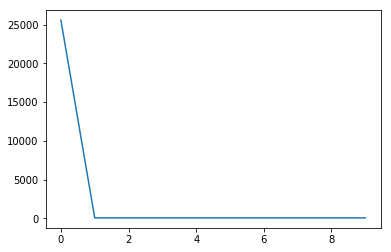

In [220]:
plt.plot(cum_loss)